In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

Load the images

In [2]:
dataset_path = Path('dataset')
left_path = dataset_path / 'left'
right_path = dataset_path / 'right'

left_image_paths = sorted(left_path.glob('*.png'))
right_image_paths = sorted(right_path.glob('*.png'))

left_imges = []
right_images = []

for left_image, right_image in zip(left_image_paths, right_image_paths):
	left = cv2.imread(str(left_image))
	right = cv2.imread(str(right_image))
	left = cv2.cvtColor(left, cv2.COLOR_BGR2RGB)
	right = cv2.cvtColor(right, cv2.COLOR_BGR2RGB)
	left_imges.append(left)
	right_images.append(right)

Create the Charuco dictionary

In [3]:
squaresX = 11
squaresY = 8
square_size = 0.05 # meters
marker_size = square_size * 0.8 # meters
aruco_dictionary = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_1000)
board = cv2.aruco.CharucoBoard_create(
	squaresX, squaresY,
	square_size,
	marker_size,
	aruco_dictionary
)

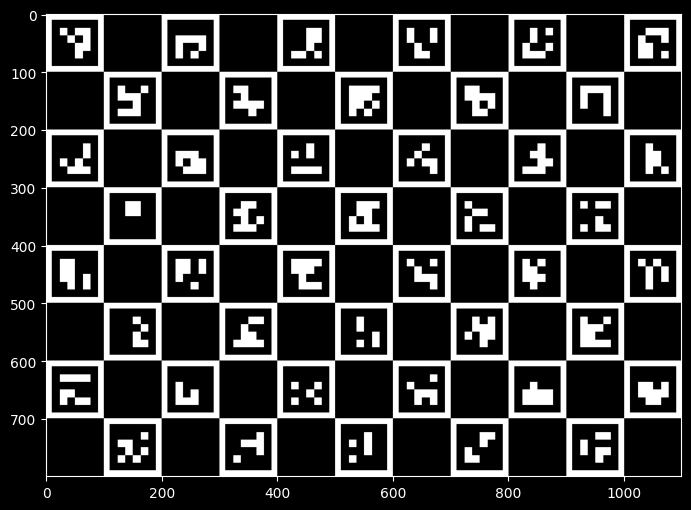

In [4]:
img = board.draw((squaresX * 100, squaresY * 100))
plt.figure(figsize=(10, 6))
plt.imshow(img, cmap='gray')

### Analyze one image

In [5]:
img = left_imges[0]
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [6]:
marker_corners, marker_ids, rejectedImgPoints = cv2.aruco.detectMarkers(
	img, aruco_dictionary)
marker_corners, marker_ids, refusd, recoverd = cv2.aruco.refineDetectedMarkers(
	img, board,
	marker_corners, marker_ids, rejectedCorners=rejectedImgPoints
)

print(f"Detected {len(marker_corners)} markers")

Detected 43 markers


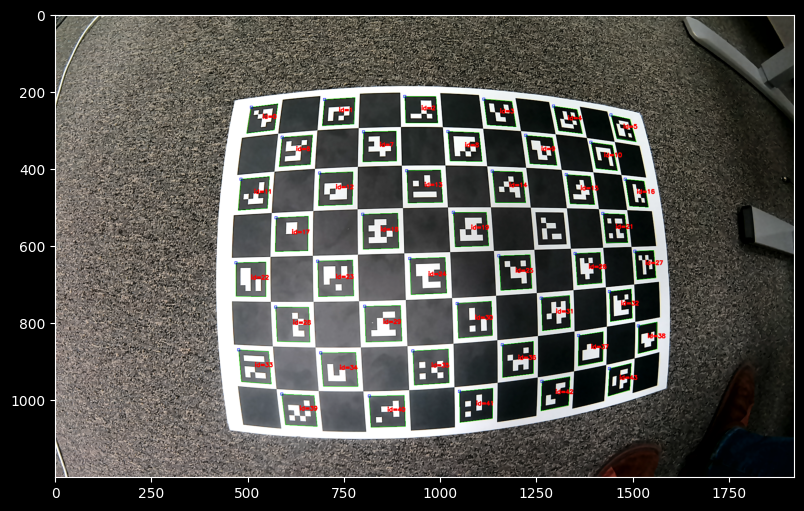

In [7]:
vis = cv2.aruco.drawDetectedMarkers(img.copy(), marker_corners, marker_ids)
plt.figure(figsize=(10, 6))
plt.imshow(vis)

In [8]:
retval, corners, ids = cv2.aruco.interpolateCornersCharuco(marker_corners, marker_ids, img_gray, board)

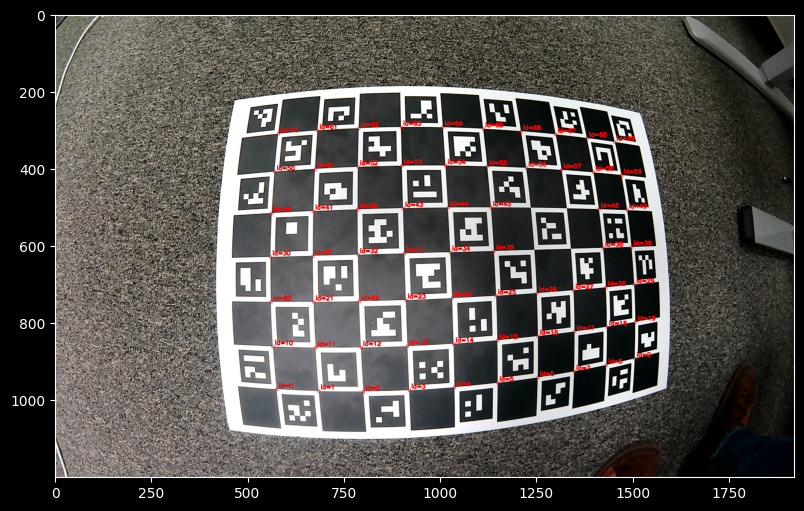

In [9]:
vis = cv2.aruco.drawDetectedCornersCharuco(img.copy(), corners, ids)
plt.figure(figsize=(10, 6))
plt.imshow(vis)

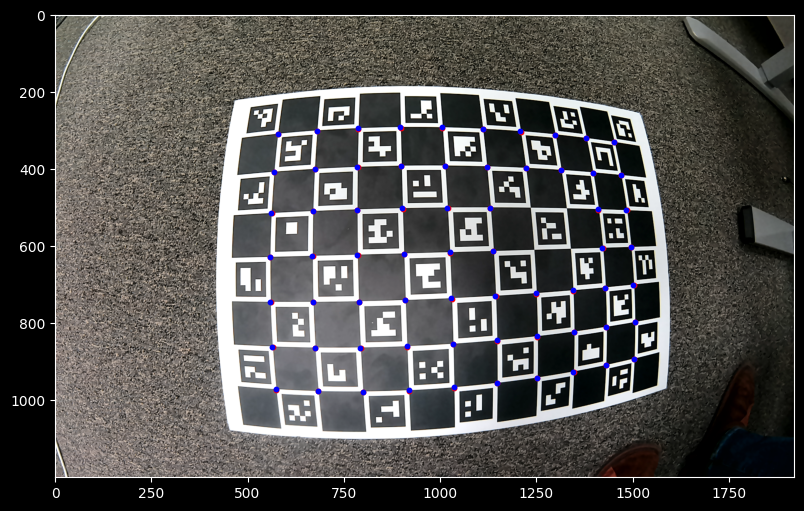

In [10]:
corners_subpix = cv2.cornerSubPix(img_gray, corners.copy(), (11, 11), (-1, -1), (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))


plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.scatter(corners[:, 0, 0], corners[:, 0, 1], c='r', s=10)
plt.scatter(corners_subpix[:, 0, 0], corners_subpix[:, 0, 1], c='b', s=10)

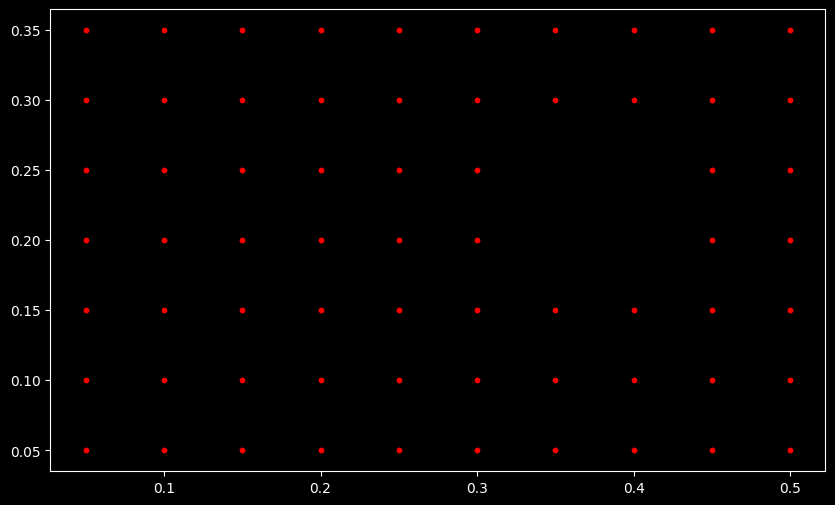

In [11]:
plt.figure(figsize=(10, 6))
cc = board.chessboardCorners[ids]
plt.scatter(cc[:, 0, 0], cc[:, 0, 1], c='r', s=10)

In [12]:
obj_points, img_points = cv2.aruco.getBoardObjectAndImagePoints(board, corners, ids)
img_points_subpix = cv2.cornerSubPix(img_gray, img_points.copy(), (11, 11), (-1, -1), (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))

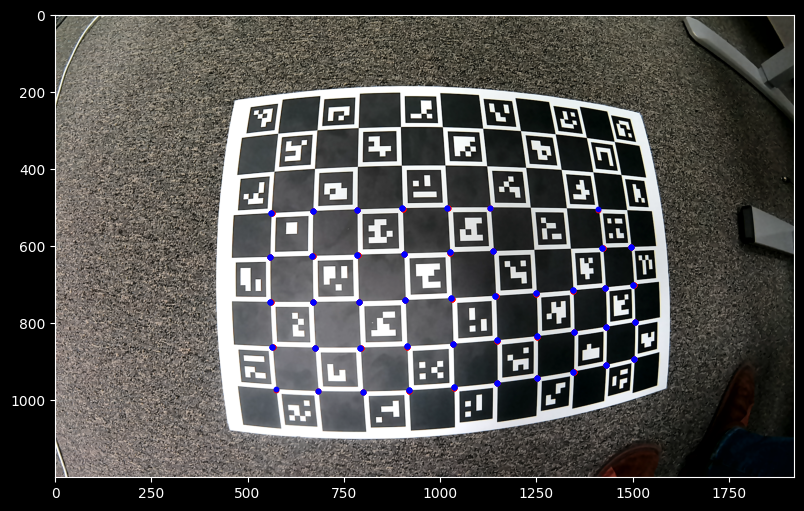

In [13]:
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.scatter(img_points[:, 0, 0], img_points[:, 0, 1], c='r', s=10)
plt.scatter(img_points_subpix[:, 0, 0], img_points_subpix[:, 0, 1], c='b', s=10)

### Analyze all images

In [14]:
def analyze_images(images):
	all_obj_points, all_img_points, all_ids = [], [], []
	for image in images:
		marker_corners, marker_ids, rejectedImgPoints = cv2.aruco.detectMarkers(image, aruco_dictionary)
		marker_corners, marker_ids, refusd, recoverd = cv2.aruco.refineDetectedMarkers(
			img, board,
			marker_corners, marker_ids, rejectedCorners=rejectedImgPoints
		)
		retval, corners, ids = cv2.aruco.interpolateCornersCharuco(marker_corners, marker_ids, img_gray, board)
		corners_subpix = cv2.cornerSubPix(img_gray, corners.copy(), (11, 11), (-1, -1), (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))

		obj_points = board.chessboardCorners[ids]

		all_obj_points.append(obj_points)
		all_img_points.append(corners_subpix)
		all_ids.append(ids)

	return all_obj_points, all_img_points, all_ids

In [15]:
all_left_obj_points, all_left_img_points, all_left_ids = analyze_images(left_imges)
all_right_obj_points, all_right_img_points, all_right_ids = analyze_images(right_images)

In [16]:
a = np.array([1, 3,4,5])
b = np.array([1,2,3  ,5])

c = np.intersect1d(a, b).reshape(-1, 1)

print(a[np.in1d(a, c)])
print(b[np.in1d(b, c)])

[1 3 5]
[1 3 5]


In [17]:
all_common_obj_points = []
all_common_left_img_points = []
all_common_right_img_points = []
for left_ids, left_img_points, right_ids, right_img_points in zip(all_left_ids, all_left_img_points, all_right_ids, all_right_img_points):
	common_ids = np.intersect1d(left_ids, right_ids)
	common_obj_points = board.chessboardCorners[common_ids.reshape(-1, 1)]
	common_left_img_points = left_img_points[np.in1d(left_ids, common_ids)]
	common_right_img_points = right_img_points[np.in1d(right_ids, common_ids)]

	all_common_obj_points.append(common_obj_points)
	all_common_left_img_points.append(common_left_img_points)
	all_common_right_img_points.append(common_right_img_points)

In [18]:
retval_l, camera_matrix_l, dist_coeff_l, _, _ = cv2.fisheye.calibrate(all_left_obj_points, all_left_img_points, img_gray.shape[::-1], None, None)
retval_r, camera_matrix_r, dist_coeff_r, _, _ = cv2.fisheye.calibrate(all_right_obj_points, all_right_img_points, img_gray.shape[::-1], None, None)
print(f"{retval_l=}\n\n camera matrix L=\n{camera_matrix_l}\n\n dist coeff L={dist_coeff_l.flatten()}")
print(f"{retval_r=}\n\n camera matrix R=\n{camera_matrix_r}\n\n dist coeff R={dist_coeff_r.flatten()}")

retval_l=231.98792233490315

 camera matrix L=
[[720.88708074 -10.20373846 960.38992967]
 [  0.         716.73600384 596.14155932]
 [  0.           0.           1.        ]]

 dist coeff L=[-0.25661438  1.55634446 -2.11744203  0.58190483]
retval_r=253.5938075994147

 camera matrix R=
[[734.57287674  -2.23154483 963.09291859]
 [  0.         725.11881403 606.3798325 ]
 [  0.           0.           1.        ]]

 dist coeff R=[-0.40667504  1.58925633 -1.43577052  0.21371704]


In [33]:
flags = 0
# flags |= cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC
# flags |= cv2.fisheye.CALIB_CHECK_COND
flags |= cv2.fisheye.CALIB_FIX_K1
flags |= cv2.fisheye.CALIB_FIX_K2
flags |= cv2.fisheye.CALIB_FIX_K3
flags |= cv2.fisheye.CALIB_FIX_K4
flags |= cv2.fisheye.CALIB_FIX_SKEW
flags |= cv2.fisheye.CALIB_FIX_INTRINSIC
# flags |= cv2.fisheye.CALIB_USE_INTRINSIC_GUESS

stereocalib_criteria = (cv2.TERM_CRITERIA_COUNT + cv2.TERM_CRITERIA_EPS, 1000, 1e-9)


cv2.fisheye.stereoCalibrate(
	all_common_obj_points, all_common_left_img_points, all_common_right_img_points,
	camera_matrix_l, dist_coeff_l, camera_matrix_r, dist_coeff_r, img_gray.shape[::-1],
	criteria=stereocalib_criteria, flags=flags
)

error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\core\src\matrix_wrap.cpp:1165: error: (-215:Assertion failed) !fixedSize() || ((Mat*)obj)->size.operator()() == _sz in function 'cv::_OutputArray::create'


##### References
- https://answers.opencv.org/question/213931/assertion-failed-abs_max-threshold-in-function-stereocalibrate/
- https://answers.opencv.org/question/67855/opencv-error-assertion-failed-abs_max-threshold-in-stereocalibrate/

In [ ]:
all_common_left_img_points[0].shape

(66, 1, 2)

In [ ]:
for left_img_points, right_img_points in zip(all_common_left_img_points, all_common_right_img_points):
	print(np.mean(np.sqrt(np.sum((left_img_points - right_img_points)**2, axis=-1))))

170.3967
161.06355
206.02672
214.29185
129.94926
153.4811
129.36243
117.52753
144.93968
125.13456
178.05647
178.9939
179.02206


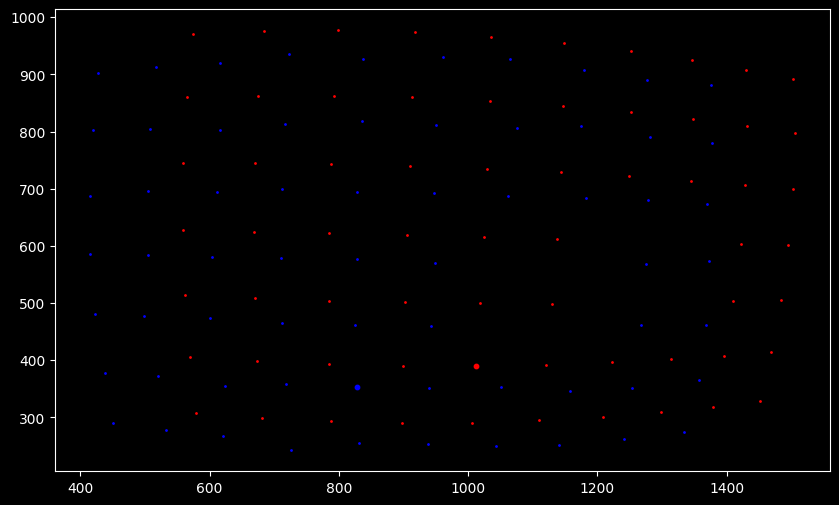

In [ ]:
plt.figure(figsize=(10, 6))
i = 50
plt.scatter(all_common_left_img_points[0][:, 0, 0], all_common_left_img_points[0][:, 0, 1], c='r', s=1)
plt.scatter(all_common_right_img_points[0][:, 0, 0], all_common_right_img_points[0][:, 0, 1], c='b', s=1)
plt.scatter(all_common_left_img_points[0][i, 0, 0], all_common_left_img_points[0][i, 0, 1], c='r', s=10)
plt.scatter(all_common_right_img_points[0][i, 0, 0], all_common_right_img_points[0][i, 0, 1], c='b', s=10)